# --- SETUP ---

In [ ]:
# --- INSTALLS AND IMPORTS ---
!pip install h5py
!pip install awscli
import os # Navigating file system
import pandas as pd # Creating dataframes
import h5py # Opening .h5 files
import matplotlib.pyplot as plt # Plotting
import numpy as np # Matrix and general math
import random # Random number generation
import tensorflow as tf # Base ML library
from tensorflow import keras # TensorFlow abstractions
from keras import layers # Custom TensorFlow layers
import awscli # For accessing AWS dataset
import subprocess # For running AWS commands
from google.colab import drive # For connecting to user's Drive
from tensorflow.keras.models import load_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9


In [ ]:
# --- MOUNT GOOGLE DRIVE ---
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# --- SETUP OPTIONS ---
# Train or inference option
script_mode = 'inference'

# Debug options
# 0: Only print essential messages
# 1: Print more info
# 2: Print debugging messages
# 3: Plot figures
verbose = 3
p_truncate = 1.0 # Proportion of data to retain for training, validation, testing
save_figs = True

# Data filtering options
# Specify target sensor modalities as list
# vis - visible satellight imagery
# ir069 - infrared satellight imagery (water vapor)
# ir107 - infrared satellite imagery (window)
# vil - vertically integrated liquid
# lght - lightning
target_sensors = ['vil']
# Specify target years
target_years = [2019]
# Specify maximum amount of data that can be missing
pct_missing = 0.0
# Specify weather conditions
only_storms = True

# Sensor scaling values
# For scaling pixel values to ~0.0-1.0
vil_scale = [0, 255]
ir069_scale = [-8000, -1000]
ir107_scale = [-7000, 5000]
vis_scale = None # Not estimated yet
# Create searchable dictionary
scale_dict = {'vil': vil_scale, 'ir069': ir069_scale, 'ir107': ir107_scale, 'vis': vis_scale}

# Input feature and label properties
img_size = 192
img_shape = (img_size, img_size, len(target_sensors))
label_shape = (img_shape[0] * img_shape[1] * img_shape[2])
img_dtype = np.float32
patch_size = 24
mask_prop = 0.50 # Proportion of image masked
mask_val = 1.0 # Values of pixels in mask

# Dataset Split
p_train = 0.8
p_val = 0.1
p_test = (1 - p_train - p_val)
n_event = 49 # Number of images in a single event

# Dataset properties
batch_size = 256
shuffle_buffer = 4048

# Learning properties
learning_rate = 0.001
end_learning_rate = learning_rate * 0.5
beta_1 = 0.9
beta_2 = 0.999
dropout_rate = 0.3
num_epochs = 100

# Network architecture
include_cls = False
# # Small ViT
# projection_dim=32
# transformer_layers=4
# num_heads=4
# mlp_head_units=[512, 256]
# Medium ViT
projection_dim=64
transformer_layers=8
num_heads=4
mlp_head_units=[2048, 1024]
# # Vit-Base
# projection_dim = 128
# transformer_layers = 12
# num_heads = 12
# mlp_head_units = [3072]

# Plot properties
cmap = 'viridis'
plot_min = 0.0 # Min val for color scaling
plot_max = 1.0 # Max val for color scaling
saved_inferences = 5 # Amount of inference results to save as images

# --- DOWNLOAD AND FILTER DATA ---

In [ ]:
# --- HELPER FUNCTIONS FOR ACCESSING AWS DATASET ---
# Print all SEVIR file paths with AWS CLI
# Prints success or error message
def print_sevir_paths():
    cmd = ['aws', 's3', 'ls', 's3://sevir', '--recursive', '--no-sign-request']
    # Execute the command with AWS CLI
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if result.returncode == 0:
        # Success
        print(result.stdout)
    else:
        # Fail
        print('Error:', result.stderr)

# Download file with AWS CLI into current directory
# Returns True if successful
def download_public_aws_file(bucket, key):
    s3_path = 's3://' + bucket + '/' + key
    cmd = ['aws', 's3', 'cp', s3_path, '.', '--no-sign-request']
    # Execute the command with AWS CLI
    result = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=False)
    if result.returncode == 0:
        # File downloaded successfully
        return True
    else:
        # File download failed
        return False

In [ ]:
# --- DOWNLOAD CATALOG ---
if os.path.exists('CATALOG.csv') == False:
    # Download catalog from AWS
    download_public_aws_file('sevir', 'CATALOG.csv')
# Read catalog as csv
catalog_df = pd.read_csv('CATALOG.csv',parse_dates=['time_utc'],low_memory=False)
if verbose > 0:
    # Print catalog properties
    print(f'Catalog shape: {catalog_df.shape}')

Catalog shape: (76004, 21)


In [ ]:
# --- FILTER EVENTS BY ID ---
# Create filtering conditions
sensor_condition = catalog_df['img_type'].isin(target_sensors)
years_condition = catalog_df['time_utc'].dt.year.isin(target_years)
missing_condition = catalog_df['pct_missing'] <= pct_missing

# Apply sensor, years and data missing conditions
filtered_catalog_df = catalog_df[sensor_condition & years_condition & missing_condition]

# Apply storm condition
if only_storms:
    filtered_catalog_df = filtered_catalog_df[filtered_catalog_df['id'].str.startswith('S')]

# Specify which catalog columns to keep
catalog_cols = ['id', 'file_name', 'file_index', 'img_type', 'size_x', 'size_y', 'height_m', 'width_m', 'data_min', 'data_max', 'pct_missing']
filtered_catalog_df = filtered_catalog_df[catalog_cols]

# Keep track of what sensor modalities are associated with each ID
# Create a dictionary mapping IDs --> sensor types
# Initialize dictionary with empty sets as values
all_ids_dict = {}
for event_id in filtered_catalog_df['id']:
    all_ids_dict[event_id] = set()

# Add sensors to sets in all_ids_dict
for index, event_id in filtered_catalog_df['id'].iteritems():
    sensor = filtered_catalog_df.at[index, 'img_type']
    all_ids_dict[event_id].add(sensor)

# Create set of valid ids that have data from all sensors
valid_ids = set()
for event_id in all_ids_dict:
    sensors = all_ids_dict[event_id]
    if sensors == set(target_sensors):
        valid_ids.add(event_id)

# Filter catalog further
valid_condition = filtered_catalog_df['id'].isin(list(valid_ids))
valid_catalog_df = filtered_catalog_df[valid_condition]
if verbose > 0:
    print(f'Catalog shape: {catalog_df.shape}')
    print(f'Filtered catalog shape: {filtered_catalog_df.shape}')
    print(f'Valid catalog shape: {valid_catalog_df.shape}')

# Filenames containing valid events
valid_filenames = set(valid_catalog_df['file_name'].tolist())
if verbose > 1:
    print(f'{len(valid_filenames)} valid filenames:')
    for filename in valid_filenames:
        print(filename)

Catalog shape: (76004, 21)
Filtered catalog shape: (1051, 11)
Valid catalog shape: (1051, 11)
2 valid filenames:
vil/2019/SEVIR_VIL_STORMEVENTS_2019_0701_1231.h5
vil/2019/SEVIR_VIL_STORMEVENTS_2019_0101_0630.h5


<ipython-input-6-f726ba5cd980>:26: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, event_id in filtered_catalog_df['id'].iteritems():


In [ ]:
# --- DOWNLOAD SENSOR DATA ---
for filename in valid_filenames:
    # AWS file path
    file_path = 'data/' + filename
    # Local filename
    local_filename = file_path.split('/')[-1]
    if os.path.exists(local_filename) == False:
        if verbose > 0:
            print(f'Downloading {file_path}...')
        download_public_aws_file('sevir', file_path)
        if verbose > 0:
            print('Download complete!')
    else:
        if verbose > 0:
            print(f'{file_path} already downloaded...')

Download complete!
Download complete!


In [ ]:
# --- CREATE ID AND SENSOR LOOKUP DICTIONARY ---
# Create dictionary to search for filename and event index based on event ID and sensor modality
# Ex) ids_dict[event_id][sensor] = (filename, idx)

# Initialize empty super-dictionary
ids_dict = {event_id: {} for event_id in valid_ids}

# Iterate through every row of the valid catalog dataframe and populate sub-dictionaries
n_id_entries = 0
for index, row in valid_catalog_df.iterrows():
    event_id = row['id']
    sensor = row['img_type']
    filename = row['file_name']
    idx = row['file_index']
    # Populate sub-dictionaries
    ids_dict[event_id][sensor] = (filename, idx)
    n_id_entries += 1

if verbose > 1:
    print(f'{n_id_entries} entries added to ids_dict')

1051 entries added to ids_dict


# --- CREATE TF DATASETS ---

In [ ]:
# --- CREATE LISTS OF TRAINING, VALIDATION, TEST IDS ---
# Create shuffled list of valid IDs
shuffled_ids = list(valid_ids)
random.shuffle(shuffled_ids)
# Split shuffled IDs into training, validation and test IDs
train_split = int(len(shuffled_ids)*p_train)
val_split = train_split + int(len(shuffled_ids)*p_val)
train_ids = shuffled_ids[:train_split]
val_ids = shuffled_ids[train_split:val_split]
test_ids = shuffled_ids[val_split:]
# Truncate datasets if necessary
if p_truncate < 1.0:
    if verbose >= 0:
        print(f'Truncating datasets...')
    train_split = int(len(train_ids)*p_truncate)
    val_split = int(len(val_ids)*p_truncate)
    test_split = int(len(test_ids)*p_truncate)
    train_ids = train_ids[:train_split]
    val_ids = val_ids[:val_split]
    test_ids = test_ids[:test_split]
# Print split properties
n_train = n_event*len(train_ids)
n_val = n_event*len(val_ids)
n_test = n_event*len(test_ids)
# Steps per epoch
steps_per_epoch = np.ceil(n_train/batch_size)
if verbose > 0:
    print(f'Length of training, validation and test ids: {len(train_ids)}, {len(val_ids)}, {len(test_ids)}')
    print(f'Length of training, validation and test examples: {n_train}, {n_val}, {n_test}')

Length of training, validation and test ids: 840, 105, 106
Length of training, validation and test examples: 41160, 5145, 5194


In [ ]:
# --- .h5 PROCESSING HELPER FUNCTIONS ---
# Gets one event from saved .h5 files
# Returns as 4D array (# imgs, img size, img size, # channels)
def get_one_event(event_id, sensor, ids_dict):
    # Generate paths to files
    file_path, idx = ids_dict[event_id][sensor]
    file_path = file_path.split('/')[-1]
    # Read .h5 file
    event = None
    with h5py.File(file_path, 'r') as hf:
        event = hf[sensor][idx]
    # Reorder axes
    event =  tf.transpose(event, perm=[2,0,1])
    # Add channel axes
    event = tf.expand_dims(event, axis=-1)
    return event

# Given a list of multiple events, concatenates them along the channel axis
# Changes resolution based on user input or lowest resultion image
def concat_event_channels(events, img_size=None):
    # Define resolution of concatenated event
    if img_size == None:
        img_size = float('inf')
        for event in events:
            if event.shape[1] < img_size:
                img_size = event.shape[1]

    # Adjust resolution
    for i in range(len(events)):
      events[i] = tf.image.resize(events[i], (img_size, img_size))

    # Concatenate events
    concat_event = tf.concat(events, axis=-1)
    return concat_event

In [ ]:
# --- DEFINE DATA GENERATORS ---
# Loads concatenated events into dataset
def load_train_data():
    empty_label = tf.zeros(label_shape)
    for input_id in train_ids:
        # Create event where each channel is a sensor type
        events = []
        for sensor in target_sensors:
            event = get_one_event(input_id, sensor, ids_dict)
            events.append(event)
        concat_event = concat_event_channels(events, img_size=img_size)
        # Add each image in the event to the dataset
        for i in range(concat_event.shape[0]):
          image = concat_event[i,:,:,:]
          yield image, empty_label

# Loads concatenated events into dataset
def load_val_data():
    empty_label = tf.zeros(label_shape)
    for input_id in val_ids:
        # Create event where each channel is a sensor type
        events = []
        for sensor in target_sensors:
            event = get_one_event(input_id, sensor, ids_dict)
            events.append(event)
        concat_event = concat_event_channels(events, img_size=img_size)
        # Add each image in the event to the dataset
        for i in range(concat_event.shape[0]):
          image = concat_event[i,:,:,:]
          yield image, empty_label

# Loads concatenated events into dataset
def load_test_data():
    empty_label = tf.zeros(label_shape)
    for input_id in test_ids:
        # Create event where each channel is a sensor type
        events = []
        for sensor in target_sensors:
            event = get_one_event(input_id, sensor, ids_dict)
            events.append(event)
        concat_event = concat_event_channels(events, img_size=img_size)
        # Add each image in the event to the dataset
        for i in range(concat_event.shape[0]):
          image = concat_event[i,:,:,:]
          yield image, empty_label

# Tensor specs for data generators
feature_spec = tf.TensorSpec(shape=img_shape, dtype=img_dtype)
label_spec = tf.TensorSpec(shape=label_shape, dtype=img_dtype)

In [ ]:
# --- HELPER FUNCTIONS TO APPLY MASK TO A SINGLE IMAGE ---
# Given an input 3D tensor mask, patch size, and patch coordinate, returns a
# new 3D tensor mask with the patch added
def add_patch_to_mask(input_mask, patch_size, r_idx, c_idx):
    # Get input shape
    height = input_mask.shape[0]
    width = input_mask.shape[1]
    channels = input_mask.shape[2]

    # Calculate padding for each dimension
    # Rows
    rows_above = r_idx
    rows_below = height - patch_size - rows_above
    # Cols
    cols_left = c_idx
    cols_right = width - patch_size - cols_left

    # Define padding
    paddings = [[rows_above, rows_below], [cols_left, cols_right], [0, 0]]

    # Create patch
    patch = tf.ones([patch_size, patch_size, channels], dtype=tf.bool)

    # Create patch mask with padding
    patch_mask = tf.pad(patch, paddings, mode='CONSTANT', constant_values=False)

    # Create true values for mask
    ones_mat = tf.ones(input_mask.shape, dtype=tf.bool)

    # Create output mask
    # Inserts patch_mask true values into input_mask
    input_mask = tf.where(patch_mask, ones_mat, input_mask)

    return input_mask

# Masks off a specified proportion of the image according to patch positions
def mask_image(input_image, patch_size, mask_prop=0.50, mask_val=0.50):
    # Color channels of image
    n_channels = input_image.shape[2]
    # How many patches can fit vertically
    patch_rows = int(input_image.shape[0]/patch_size)
    # How many patches can fit horizontally
    patch_cols = int(input_image.shape[1]/patch_size)
    # How many patches to mask in the image
    n_mask = int(patch_rows*patch_cols*mask_prop)

    # Create empty image mask
    image_mask = tf.zeros(input_image.shape, dtype=tf.bool)

    # Determine locations for masked patches
    mask_pos = tf.random.shuffle(tf.range(patch_rows * patch_cols))

    # Fill mask
    for i in range(n_mask):
        # Calculate row index and column index from patch_pos
        patch_r_idx = (mask_pos[i] // patch_cols) * patch_size
        patch_c_idx = (mask_pos[i] % patch_cols) * patch_size
        # Put patch mask in image_mask
        image_mask = add_patch_to_mask(image_mask, patch_size, patch_r_idx, patch_c_idx)

    # Create true values for image mask
    vals_mat = np.full(input_image.shape, mask_val, dtype=img_dtype)

    # Mask input image
    # Inserts vals into input_image based on image_mask
    input_image = tf.where(image_mask, vals_mat, input_image)
    return input_image

In [ ]:
# --- HELPER FUNCTION TO CREATE A SINGLE EXAMPLE ---
# Given batch of single channel images, linearly scales channel values according to input limits
def scale_img_channel(imgs, lims):
    return (imgs - lims[0])/(lims[1] - lims[0])

# Takes a single 3D image of shape (img size, img size, # channels)
def create_example(image, label):
    # Rescale each image channel
    img_channels = []
    for count, sensor in enumerate(target_sensors):
        scale = scale_dict[sensor]
        scaled_channel = scale_img_channel(image[:,:,count], scale)
        scaled_channel = tf.expand_dims(scaled_channel, axis=-1)
        img_channels.append(scaled_channel)
    rescaled_image = tf.concat(img_channels, axis=-1)
    # Create flattened label from image
    label = tf.reshape(rescaled_image, [-1])
    # Mask image
    masked_image = mask_image(rescaled_image, patch_size, mask_prop=mask_prop, mask_val=mask_val)
    return masked_image, label

In [ ]:
# --- CREATE TF DATASETS ---
# Training
train_dataset = tf.data.Dataset.from_generator(load_train_data, output_signature=(feature_spec, label_spec))
# Shuffle dataset at the beginning of every epoch
train_dataset = train_dataset.shuffle(shuffle_buffer)
# Apply transformations to data
train_dataset = train_dataset.map(create_example, num_parallel_calls=tf.data.AUTOTUNE)
# Batch data
train_dataset = train_dataset.batch(batch_size)
# Prefetch data
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Validation
val_dataset = tf.data.Dataset.from_generator(load_val_data, output_signature=(feature_spec, label_spec))
# Apply transformations to data
val_dataset = val_dataset.map(create_example, num_parallel_calls=tf.data.AUTOTUNE)
# Batch data
val_dataset = val_dataset.batch(batch_size)
# Prefetch data
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

# Test
test_dataset = tf.data.Dataset.from_generator(load_test_data, output_signature=(feature_spec, label_spec))
# Apply transformations to data
test_dataset = test_dataset.map(create_example, num_parallel_calls=tf.data.AUTOTUNE)
# Batch data
test_dataset = test_dataset.batch(batch_size)
# Prefetch data
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

Feature batch shape: (256, 192, 192, 1)
Label batch shape: (256, 36864)


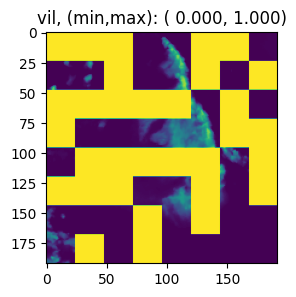

In [ ]:
# --- VISUALIZE TRAINING INPUT FEATURE ---
# Get image from training dataset
feature_batch = None
label_batch = None
for batch in train_dataset.take(1):
    feature_batch, label_batch = batch
feature_batch_shape = feature_batch.shape
label_batch_shape = label_batch.shape
if verbose > 1:
    print(f'Feature batch shape: {feature_batch_shape}')
    print(f'Label batch shape: {label_batch_shape}')

if verbose > 2:
    # Plotting parameters
    batch_idx = 0
    n_subplots = feature_batch_shape[3]
    figsize = (n_subplots*6, n_subplots*3)
    plt.figure(figsize=figsize)
    for i in range(n_subplots):
        ax = plt.subplot(1, n_subplots, i+1)
        img = feature_batch[batch_idx, :, :, i]
        max_val = tf.reduce_max(img)
        min_val = tf.reduce_min(img)
        plt.imshow(img, cmap=cmap, vmin=plot_min, vmax=plot_max)
        # plt.colorbar()
        plt.title(f'{target_sensors[i]}, (min,max): ({min_val: .3f},{max_val: .3f})')

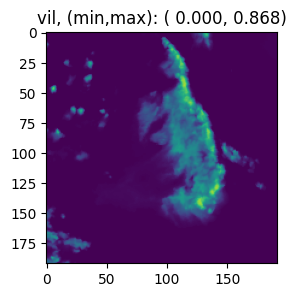

In [ ]:
# --- VISUALIZE TRAINING LABEL ---
if verbose > 2:
    # Plotting parameters
    n_subplots = feature_batch_shape[3]
    label = tf.reshape(label_batch[batch_idx, :], feature_batch[batch_idx, :, :, :].shape)
    figsize = (n_subplots*6, n_subplots*3)
    plt.figure(figsize=figsize)
    for i in range(n_subplots):
        ax = plt.subplot(1, n_subplots, i+1)
        img = label[:, :, i]
        max_val = tf.reduce_max(img)
        min_val = tf.reduce_min(img)
        plt.imshow(img, cmap=cmap, vmin=0, vmax=1.0)
        # plt.colorbar()
        plt.title(f'{target_sensors[i]}, (min,max): ({min_val: .3f},{max_val: .3f})')

# --- DEFINE MODEL ---

In [ ]:
# --- PATCHES CLASS ---
# Given a batch of images represented as a 4D tensor, returns a row of flattened
# patches for each image in the batch
class Patches(layers.Layer):
    def __init__(self, patch_size, name=None, dtype=None, **kwargs):
        super().__init__()
        # Length of one edge of square patch
        self.patch_size = patch_size

    def call(self, images):
        # Amount of images in batch
        # Images should be 4D tensor of shape (# img in batch, img width, img height, # channels)
        batch_size = tf.shape(images)[0]
        # A 4D tensor indexed by (batch, row, column, flattened patch length). The patch is
        # flattened spatially and across color channels
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # Length of flattened patch
        patch_len = patches.shape[-1]
        # Collapse unspecified axes into one axis, essentially creating a row of
        # flattened patches as each member of the batch
        # Has shape (# img in batch, # of patches, flattened patch length)
        patches = tf.reshape(patches, [batch_size, -1, patch_len])
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
        })
        return config

In [ ]:
# --- PATCH ENCODER CLASS ---
# Passes a patch through a dense layer with a learnable position embedding
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, name=None, dtype=None, **kwargs):
        super().__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        # Projects each flattened patch into vector using a dense layer
        # 3D tensor of shape (# img in batch, # of patches, projection_dim)
        self.projection = layers.Dense(units=projection_dim)
        # Creates an embedding vector for each position/patch index
        # Results in a 2D embedding table, where each element is a learnable weight
        # 2D tensor of shape (# of patches, projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # Broadcasting of the position_embedding tensor results in the same shape
        # as the projection tensor
        # The same position embedding table is applied to each image
        # 3D tensor of shape (# img in batch, # of patches, projection_dim)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim,
        })
        return config

In [ ]:
# --- CLS TOKEN CLASS ---
# Create a class token for classification tasks that is broadcasted to match batch size
class CLSToken(layers.Layer):
    def __init__(self, projection_dim, name=None, dtype=None, **kwargs):
        super().__init__()
        self.projection_dim = projection_dim
        self.cls_token = self.add_weight(shape=(1, 1, self.projection_dim))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        cls_broadcasted = tf.broadcast_to(self.cls_token, [batch_size, 1, self.projection_dim])
        return cls_broadcasted

    def get_config(self):
        config = super().get_config()
        config.update({
            "projection_dim": self.projection_dim,
        })
        return config

In [ ]:
# --- MULTILAYER PERCEPTION CLASS ---
# Multilayer DNN with GELU activation and dropout normalization
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# --- CREATE ViT MODEL ---
# https://arxiv.org/abs/1706.03762
def ViT(input_shape, patch_size, output_dim, projection_dim=64, transformer_layers=8, num_heads=4, mlp_head_units=[2048, 1024]):
    num_patches = (input_shape[0] // patch_size) ** 2
    # Defines size of MLP
    transformer_units = [projection_dim * 2, projection_dim]

    # Create Keras tensor object based on input parameters
    inputs = layers.Input(shape=input_shape)

    # --- ENCODER ---
    # Create patches from inputs
    # Has shape (# img in batch, # of patches, flattened patch length)
    patches = Patches(patch_size)(inputs)

    # Create patch encodings
    # Has shape (# img in batch, # of patches, projection_dim)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # --- EXTRA CLASS EMBEDDING [OPTIONAL?] ---
    # Prepend a broadcasted cls token to add global context for classification tasks
    # Has shape (# img in batch, # of patches + 1, projection_dim)
    if include_cls:
        cls_broadcasted = CLSToken(projection_dim)(encoded_patches)
        encoded_patches = tf.concat([cls_broadcasted, encoded_patches], axis=1)

    # --- TRANSFORMER ---
    # Create multiple layers of the transformer block
    # Transformer blocks are not changing dimensionality of tensors
    for _ in range(transformer_layers):
        # Normalization layer
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-head attention layer with self attention
        # Boolean matrix (# img in batch, # patches)
        # Attention mask shape ()
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
        # Add layer outputs
        x2 = layers.Add()([attention_output, encoded_patches])
        # Normalization layer
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Add layer outputs and reset output as input to next transformer block
        encoded_patches = layers.Add()([x3, x2])

    # --- DECODER ---
    # Create a 2D tensor of shape (# img in batch, # patches * projection_dim)
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Input to MLP must be flattened first
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP
    inter_features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=dropout_rate)
    # Define output dimension
    logits = layers.Dense(output_dim)(inter_features)
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)

    return model

In [ ]:
# --- INITIALIZE ViT MODEL ---
vit = None
if script_mode == 'training':
  input_shape = img_shape
  output_dim = label_shape
  vit = ViT(input_shape, patch_size, output_dim, projection_dim=projection_dim, transformer_layers=transformer_layers, num_heads=num_heads, mlp_head_units=mlp_head_units)
  if verbose > 1:
      vit.summary()
elif script_mode == 'inference':
  model_path = '/content/gdrive/My Drive/Reference_Colab/Archive/ViT_071923'
  model_name = 'vit.h5'
  vit = load_model(model_path+'/'+model_name, custom_objects={'Patches': Patches, 'PatchEncoder': PatchEncoder, 'CLSToken': CLSToken})

NameError: ignored

# --- TRAIN MODEL ---

In [ ]:
# --- DEFINE LEARNING RATE SCHEDULE ---
# Linear learning rate schedule
total_steps = num_epochs*(n_train//batch_size)
lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    learning_rate, total_steps, end_learning_rate, power=1.0)  # power=1.0 means linear decay

NameError: ignored

In [ ]:
# --- DEFINE EXPERIMENT PARAMETERS AND TRAIN MODEL ---
def run_experiment(model):
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr_schedule,
        beta_1=beta_1,
        beta_2=beta_2,
    )

    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
    )

    return history

history = None
if script_mode == 'train':
  history = run_experiment(vit)

# --- SAVE AND EVALUATE MODEL ---

In [ ]:
# --- SAVE MODEL ---
if script_mode == 'train':
  my_drive_path = '/content/gdrive/My Drive/Reference_Colab/'
  vit.save(my_drive_path + 'vit.h5')

In [ ]:
# --- PLOT TRAINING HISTORY ---
if script_mode == 'train':
  if save_figs == True:
      plt.figure(figsize=(8, 4))
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model Loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')
      plt.savefig(my_drive_path + 'train_loss.png')
      if verbose > 2:
          plt.show()

1/1 [==============================] - 0s 137ms/step


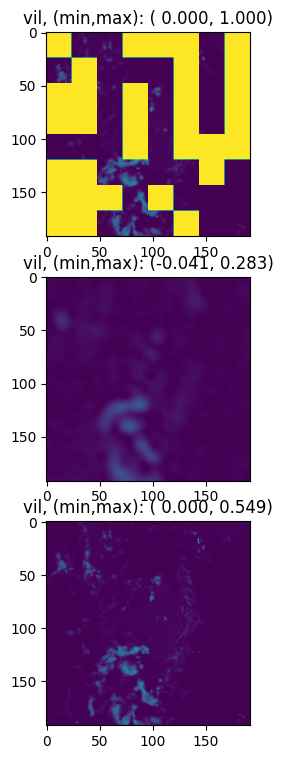

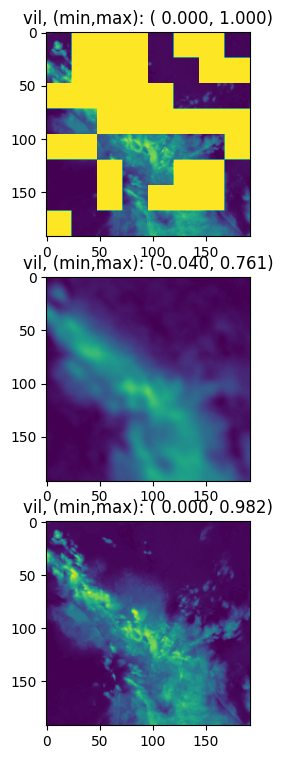

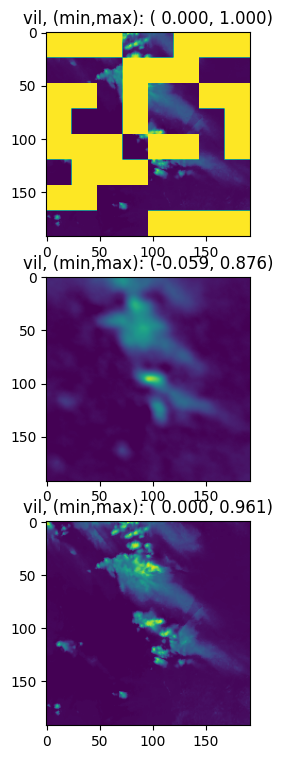

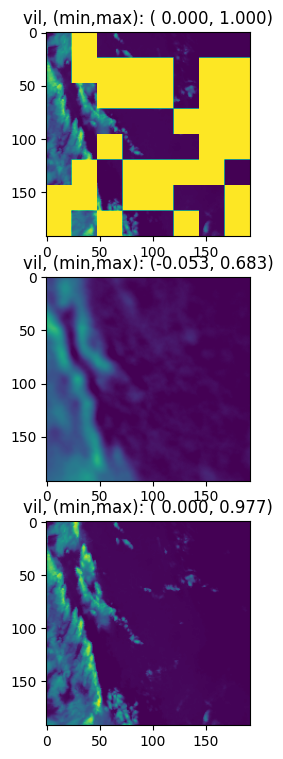

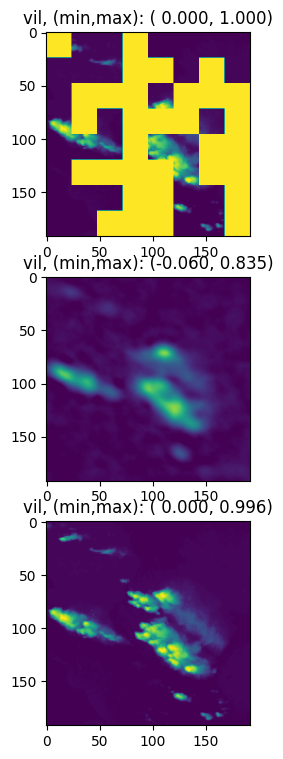

In [ ]:
# --- SAVE TRAINING INFERENCES ---
# Get image from training dataset
n_inferences = 5
feature_batch = None
label_batch = None
for batch in train_dataset.take(1):
    feature_batch, label_batch = batch

if verbose > 2:
    batch_idx_list = random.sample(range(batch_size), k=n_inferences)
    for count in range(n_inferences):
        # Plotting parameters
        batch_idx = batch_idx_list[count]
        n_rows = 3
        n_cols = len(target_sensors)
        figsize = (n_subplots*6, n_subplots*9)
        plt.figure(figsize=figsize)
        # Plot input feature
        for i in range(n_cols):
            ax = plt.subplot(n_rows, n_cols, i+1)
            img = feature_batch[batch_idx, :, :, i]
            max_val = tf.reduce_max(img)
            min_val = tf.reduce_min(img)
            plt.imshow(img, cmap=cmap, vmin=plot_min, vmax=plot_max)
            plt.title(f'{target_sensors[i]}, (min,max): ({min_val: .3f},{max_val: .3f})')
        # Plot inference
        input = tf.expand_dims(feature_batch[batch_idx, :, :, :], axis=0)
        inference = vit.predict(input)
        inference = tf.reshape(inference, input.shape)
        for i in range(n_cols):
            ax = plt.subplot(n_rows, n_cols, n_cols+i+1)
            img = inference[0, :, :, i]
            max_val = tf.reduce_max(img)
            min_val = tf.reduce_min(img)
            plt.imshow(img, cmap=cmap, vmin=plot_min, vmax=plot_max)
            plt.title(f'{target_sensors[i]}, (min,max): ({min_val: .3f},{max_val: .3f})')
        # Plot label
        label = label_batch[batch_idx]
        label = tf.reshape(label, img_shape)
        for i in range(n_cols):
            ax = plt.subplot(n_rows, n_cols, 2*n_cols+i+1)
            img = label[:, :, i]
            max_val = tf.reduce_max(img)
            min_val = tf.reduce_min(img)
            plt.imshow(img, cmap=cmap, vmin=plot_min, vmax=plot_max)
            plt.title(f'{target_sensors[i]}, (min,max): ({min_val: .3f},{max_val: .3f})')

1/1 [==============================] - 0s 142ms/step


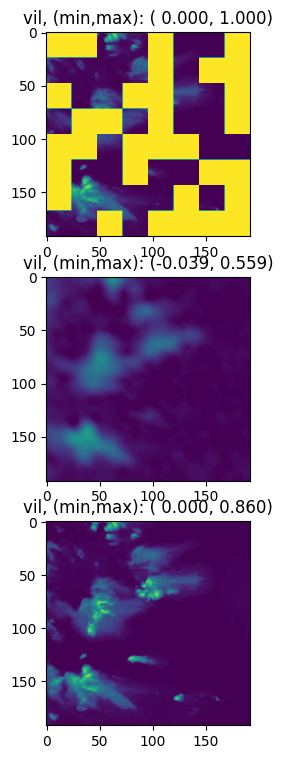

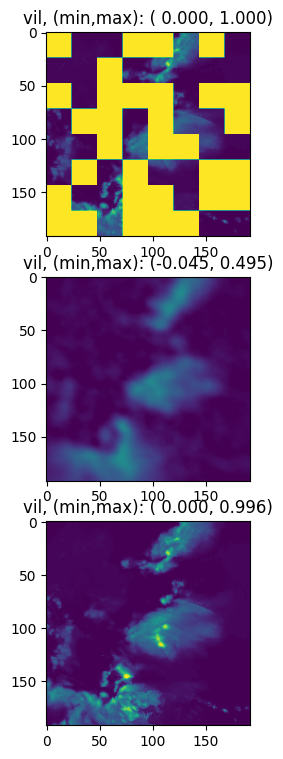

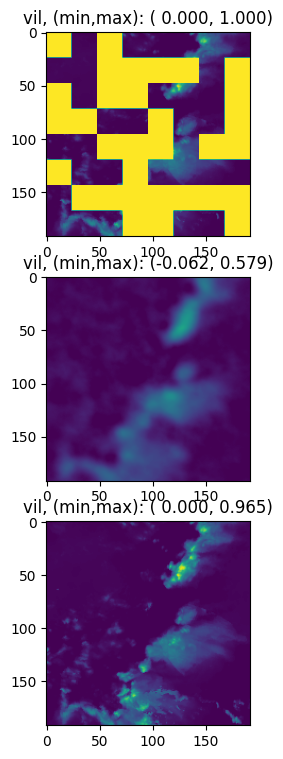

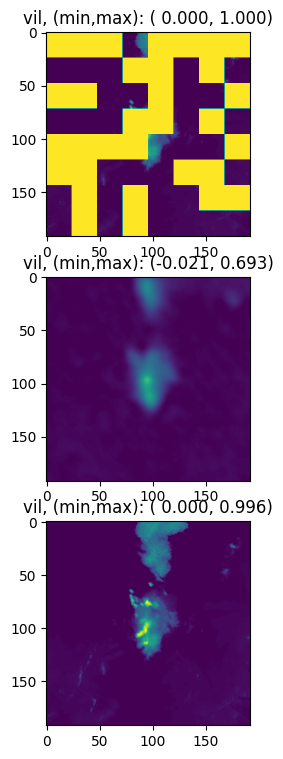

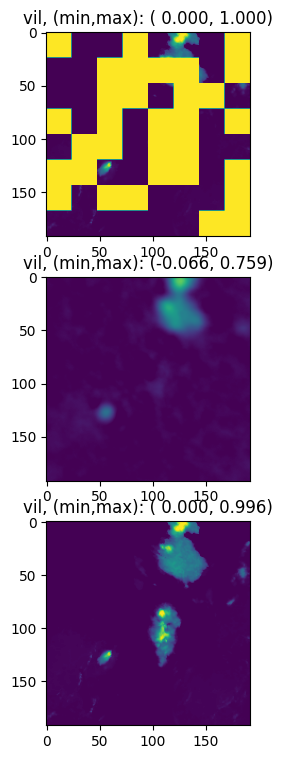

In [ ]:
# --- SAVE TEST INFERENCES ---
# Get image from training dataset
n_inferences = 5
feature_batch = None
label_batch = None
for batch in test_dataset.take(1):
    feature_batch, label_batch = batch

if verbose > 2:
    sample_range = 0
    if n_test < batch_size:
        sample_range = n_test
    else:
        sample_range = batch_size
    batch_idx_list = random.sample(range(sample_range), k=n_inferences)
    for count in range(n_inferences):
        # Plotting parameters
        batch_idx = batch_idx_list[count]
        n_rows = 3
        n_cols = len(target_sensors)
        figsize = (n_subplots*6, n_subplots*9)
        plt.figure(figsize=figsize)
        # Plot input feature
        for i in range(n_cols):
            ax = plt.subplot(n_rows, n_cols, i+1)
            img = feature_batch[batch_idx, :, :, i]
            max_val = tf.reduce_max(img)
            min_val = tf.reduce_min(img)
            plt.imshow(img, cmap=cmap, vmin=plot_min, vmax=plot_max)
            plt.title(f'{target_sensors[i]}, (min,max): ({min_val: .3f},{max_val: .3f})')
        # Plot inference
        input = tf.expand_dims(feature_batch[batch_idx, :, :, :], axis=0)
        inference = vit.predict(input)
        inference = tf.reshape(inference, input.shape)
        for i in range(n_cols):
            ax = plt.subplot(n_rows, n_cols, n_cols+i+1)
            img = inference[0, :, :, i]
            max_val = tf.reduce_max(img)
            min_val = tf.reduce_min(img)
            plt.imshow(img, cmap=cmap, vmin=plot_min, vmax=plot_max)
            plt.title(f'{target_sensors[i]}, (min,max): ({min_val: .3f},{max_val: .3f})')
        # Plot label
        label = label_batch[batch_idx]
        label = tf.reshape(label, img_shape)
        for i in range(n_cols):
            ax = plt.subplot(n_rows, n_cols, 2*n_cols+i+1)
            img = label[:, :, i]
            max_val = tf.reduce_max(img)
            min_val = tf.reduce_min(img)
            plt.imshow(img, cmap=cmap, vmin=plot_min, vmax=plot_max)
            plt.title(f'{target_sensors[i]}, (min,max): ({min_val: .3f},{max_val: .3f})')

In [ ]:
# --- EVALUATE MODEL ---
if script_mode == 'train':
  test_loss, test_accuracy = vit.evaluate(test_dataset)
  if verbose >= 0:
      print(f'Test loss and accuracy: {test_loss}, {test_accuracy}')